# Weather's Effect on Solar Generation

## 1. Introduction
As a solar salesman and business owner, I have domain experience in the renewable energy space. While solar may seem like the best solution to energy production. However, solar can only produce so much power during so many hours of the day. The goal of this model is to try to predict solar production using the production readings of other generation methods and weather data.

## 2. Question

### Can I predict solar generation using weather data and other generation readings for the day?

## 3. Data
The data comes from [kaggle](https://www.kaggle.com/nicholasjhana/energy-consumption-generation-prices-and-weather) split into two datasets. The first contains 35,064 observations. These observations include a column of instantaeously captured production levels of solar systems for each hour for four years, aggregated across Spain. The second database includes weather information at the same resolution for each of the five major cities in Spain. I intend to average the cities' weather data to represent the effective weather conditions for all of spain.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import ds_useful as ds

In [2]:
try:
    raw_energy = pd.read_csv('energy_dataset.csv')
    raw_weather = pd.read_csv('weather_features.csv')
except FileNotFoundError as e:
    print(e)
    print('Attempting to read datasets from online csv files on Github')
    raw_energy = pd.read_csv('https://github.com/cobyoram/Thinkful_capstone_1/blob/master/energy_dataset.csv')
    raw_weather = pd.read_csv('https://github.com/cobyoram/Thinkful_capstone_1/blob/master/weather_features.csv')

In [3]:
print(raw_energy.info())
raw_energy.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
time                                           35064 non-null object
generation biomass                             35045 non-null float64
generation fossil brown coal/lignite           35046 non-null float64
generation fossil coal-derived gas             35046 non-null float64
generation fossil gas                          35046 non-null float64
generation fossil hard coal                    35046 non-null float64
generation fossil oil                          35045 non-null float64
generation fossil oil shale                    35046 non-null float64
generation fossil peat                         35046 non-null float64
generation geothermal                          35046 non-null float64
generation hydro pumped storage aggregated     0 non-null float64
generation hydro pumped storage consumption    35045 non-null float64
generation hydro run-of-river and poundage     35045 non

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04


In [4]:
print(raw_weather.info())
raw_weather.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178396 entries, 0 to 178395
Data columns (total 17 columns):
dt_iso                 178396 non-null object
city_name              178396 non-null object
temp                   178396 non-null float64
temp_min               178396 non-null float64
temp_max               178396 non-null float64
pressure               178396 non-null int64
humidity               178396 non-null int64
wind_speed             178396 non-null int64
wind_deg               178396 non-null int64
rain_1h                178396 non-null float64
rain_3h                178396 non-null float64
snow_3h                178396 non-null float64
clouds_all             178396 non-null int64
weather_id             178396 non-null int64
weather_main           178396 non-null object
weather_description    178396 non-null object
weather_icon           178396 non-null object
dtypes: float64(6), int64(6), object(5)
memory usage: 23.1+ MB
None


,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


## Clean the data

In [5]:
# We want to be able to combine these datasets together. So we need to aggregate the weather data across spain, and set a shared key variable using the date and time
raw_weather['date'] = pd.to_datetime(raw_weather['dt_iso'].str.replace('\+[0-9][0-9]:[0-9][0-9]', '', regex=True))
raw_energy['date'] = pd.to_datetime(raw_energy['time'].str.replace('\+[0-9][0-9]:[0-9][0-9]', '', regex=True))

In [6]:
raw_weather.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon,date
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n,2015-01-01 00:00:00
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n,2015-01-01 01:00:00
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n,2015-01-01 02:00:00
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n,2015-01-01 03:00:00
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n,2015-01-01 04:00:00


In [7]:
raw_energy.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual,date
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41,2015-01-01 00:00:00
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92,2015-01-01 01:00:00
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48,2015-01-01 02:00:00
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32,2015-01-01 03:00:00
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04,2015-01-01 04:00:00


In [8]:
# We group the weather data by the date, aggregating by mean for numerical data, and mode for categorical data
agg_weather_num = raw_weather[['date'] + list(raw_weather.select_dtypes('number').columns)].groupby(by='date').mean()
agg_weather_cat = raw_weather[['date'] + list(raw_weather.select_dtypes('object').columns)].groupby(by='date').agg(lambda x: x.value_counts(ascending=False).index[0])
# We concat the two aggregated weather datasets together to form one
agg_weather = pd.concat([agg_weather_num, agg_weather_cat], axis=1)
agg_weather.head()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,dt_iso,city_name,weather_main,weather_description,weather_icon
date,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,272.491463,272.491463,272.491463,1016.4,82.4,2.0,135.2,0.0,0.0,0.0,0.0,800.0,2015-01-01 00:00:00+01:00,Bilbao,clear,sky is clear,01n
2015-01-01 01:00:00,272.512700,272.512700,272.512700,1016.2,82.4,2.0,135.8,0.0,0.0,0.0,0.0,800.0,2015-01-01 01:00:00+01:00,Bilbao,clear,sky is clear,01n
2015-01-01 02:00:00,272.099137,272.099137,272.099137,1016.8,82.0,2.4,119.0,0.0,0.0,0.0,0.0,800.0,2015-01-01 02:00:00+01:00,Bilbao,clear,sky is clear,01n
2015-01-01 03:00:00,272.089469,272.089469,272.089469,1016.6,82.0,2.4,119.2,0.0,0.0,0.0,0.0,800.0,2015-01-01 03:00:00+01:00,Bilbao,clear,sky is clear,01n
2015-01-01 04:00:00,272.145900,272.145900,272.145900,1016.6,82.0,2.4,118.4,0.0,0.0,0.0,0.0,800.0,2015-01-01 04:00:00+01:00,Bilbao,clear,sky is clear,01n


In [9]:
# Now we join the weather and energy datasets together on the date column
energy_weather_data = pd.merge(raw_energy, agg_weather, on='date')
energy_weather_data.drop(['dt_iso', 'time'], axis=1, inplace=True)
print(energy_weather_data.columns)
# We now have weather and generation data for every hour from 2015-2018
energy_weather_data

Index(['generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual', 'date', 'temp', 'temp_min', 'temp_max', 'pressure',
       'humidity', 'wind_speed', 'wind_deg', 

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,city_name,weather_main,weather_description,weather_icon
0,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,...,135.2,0.0,0.0,0.0,0.0,800.0,Bilbao,clear,sky is clear,01n
1,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,...,135.8,0.0,0.0,0.0,0.0,800.0,Bilbao,clear,sky is clear,01n
2,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,...,119.0,0.0,0.0,0.0,0.0,800.0,Bilbao,clear,sky is clear,01n
3,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,...,119.2,0.0,0.0,0.0,0.0,800.0,Bilbao,clear,sky is clear,01n
4,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,...,118.4,0.0,0.0,0.0,0.0,800.0,Bilbao,clear,sky is clear,01n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,NaN,...,151.4,0.0,0.0,0.0,0.0,800.0,Bilbao,clear,sky is clear,01n
35060,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,NaN,...,160.4,0.0,0.0,0.0,0.0,800.0,Bilbao,clear,sky is clear,01n
35061,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,NaN,...,226.0,0.0,0.0,0.0,0.0,800.0,Bilbao,clear,sky is clear,01n
35062,293.0,0.0,0.0,6562.0,2293.0,163.0,0.0,0.0,0.0,NaN,...,230.0,0.0,0.0,0.0,0.0,800.0,Bilbao,clear,sky is clear,01n


In [10]:
# Next we get rid of columns that are missing too much data
missings = ds.missingness_summary(energy_weather_data, print_log=True)
ew_clean = energy_weather_data.drop(missings.loc[missings == 100].index, axis=1)
# There is not much missing data now, so we'll linearly interpolate the missing values to have a non-null dataset
ew_clean.interpolate(method='linear', axis=0, inplace=True, limit_direction='both')

forecast wind offshore eday ahead              100.000000
generation hydro pumped storage aggregated     100.000000
total load actual                                0.102669
generation fossil oil                            0.054187
generation hydro pumped storage consumption      0.054187
generation hydro run-of-river and poundage       0.054187
generation marine                                0.054187
generation waste                                 0.054187
generation biomass                               0.054187
generation solar                                 0.051335
generation fossil oil shale                      0.051335
generation wind offshore                         0.051335
generation wind onshore                          0.051335
generation hydro water reservoir                 0.051335
generation other renewable                       0.051335
generation fossil peat                           0.051335
generation geothermal                            0.051335
generation fos

In [11]:
# We drop columns that repeat 0 a ridiculous amount of times over the 3 years.
repeats = ds.repeats_summary(ew_clean, print_log=True)
ew_clean.drop(repeats.loc[repeats > 90].index, axis=1, inplace=True)

Repeated values: [0]
generation fossil oil shale                    100.000000
generation fossil peat                         100.000000
generation fossil coal-derived gas             100.000000
generation wind offshore                       100.000000
generation marine                              100.000000
generation geothermal                          100.000000
snow_3h                                         99.264203
rain_3h                                         95.388433
rain_1h                                         65.115218
generation hydro pumped storage consumption     35.974219
generation fossil brown coal/lignite            30.013689
clouds_all                                       6.051791
forecast solar day ahead                         1.537189
generation other                                 0.011408
generation biomass                               0.011408
wind_deg                                         0.011408
generation other renewable                       0.

## Feature Selection

In [12]:
# Print out the unique classes in each categorical variable
for col in ew_clean.select_dtypes('object').columns:
    print(col)
    print(ew_clean[col].unique())

city_name
['Bilbao' 'Valencia' 'Seville' ' Barcelona' 'Madrid']
weather_main
['clear' 'clouds' 'rain' 'fog' 'thunderstorm' 'drizzle' 'haze' 'mist'
 'snow']
weather_description
['sky is clear' 'few clouds' 'broken clouds' 'scattered clouds'
 'light rain' 'overcast clouds' 'moderate rain' 'fog' 'mist'
 'heavy intensity rain' 'thunderstorm' 'heavy intensity shower rain'
 'proximity thunderstorm' 'thunderstorm with heavy rain'
 'thunderstorm with rain' 'light intensity drizzle' 'haze' 'drizzle'
 'light intensity drizzle rain' 'shower rain'
 'light intensity shower rain' 'proximity shower rain' 'snow'
 'light shower snow' 'light rain and snow' 'light snow']
weather_icon
['01n' '01d' '01' '02' '02n' '04n' '04d' '03' '02d' '04' '03n' '10' '03d'
 '10n' '10d' '50n' '50d' '09n' '11d' '11n' '09d' '13d' '13n']


In [13]:
# Drop categorical variables that we won't need or that have too many unique clases
cat_drop_cols = ['city_name', 'weather_description', 'weather_icon']
ew_feats = ew_clean.drop(cat_drop_cols, axis=1)

In [14]:
# Create dummy variables for categorical columns
dums = pd.get_dummies(ew_feats, columns=ew_feats.select_dtypes('object').columns, drop_first=True)
dums

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,clouds_all,weather_id,weather_main_clouds,weather_main_drizzle,weather_main_fog,weather_main_haze,weather_main_mist,weather_main_rain,weather_main_snow,weather_main_thunderstorm
0,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,...,0.0,800.0,0,0,0,0,0,0,0,0
1,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,...,0.0,800.0,0,0,0,0,0,0,0,0
2,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,...,0.0,800.0,0,0,0,0,0,0,0,0
3,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,...,0.0,800.0,0,0,0,0,0,0,0,0
4,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,...,0.0,800.0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,297.0,0.0,7634.0,2628.0,178.0,1.0,1135.0,4836.0,6073.0,63.0,...,0.0,800.0,0,0,0,0,0,0,0,0
35060,296.0,0.0,7241.0,2566.0,174.0,1.0,1172.0,3931.0,6074.0,62.0,...,0.0,800.0,0,0,0,0,0,0,0,0
35061,292.0,0.0,7025.0,2422.0,168.0,50.0,1148.0,2831.0,6076.0,61.0,...,0.0,800.0,0,0,0,0,0,0,0,0
35062,293.0,0.0,6562.0,2293.0,163.0,108.0,1128.0,2068.0,6075.0,61.0,...,0.0,800.0,0,0,0,0,0,0,0,0


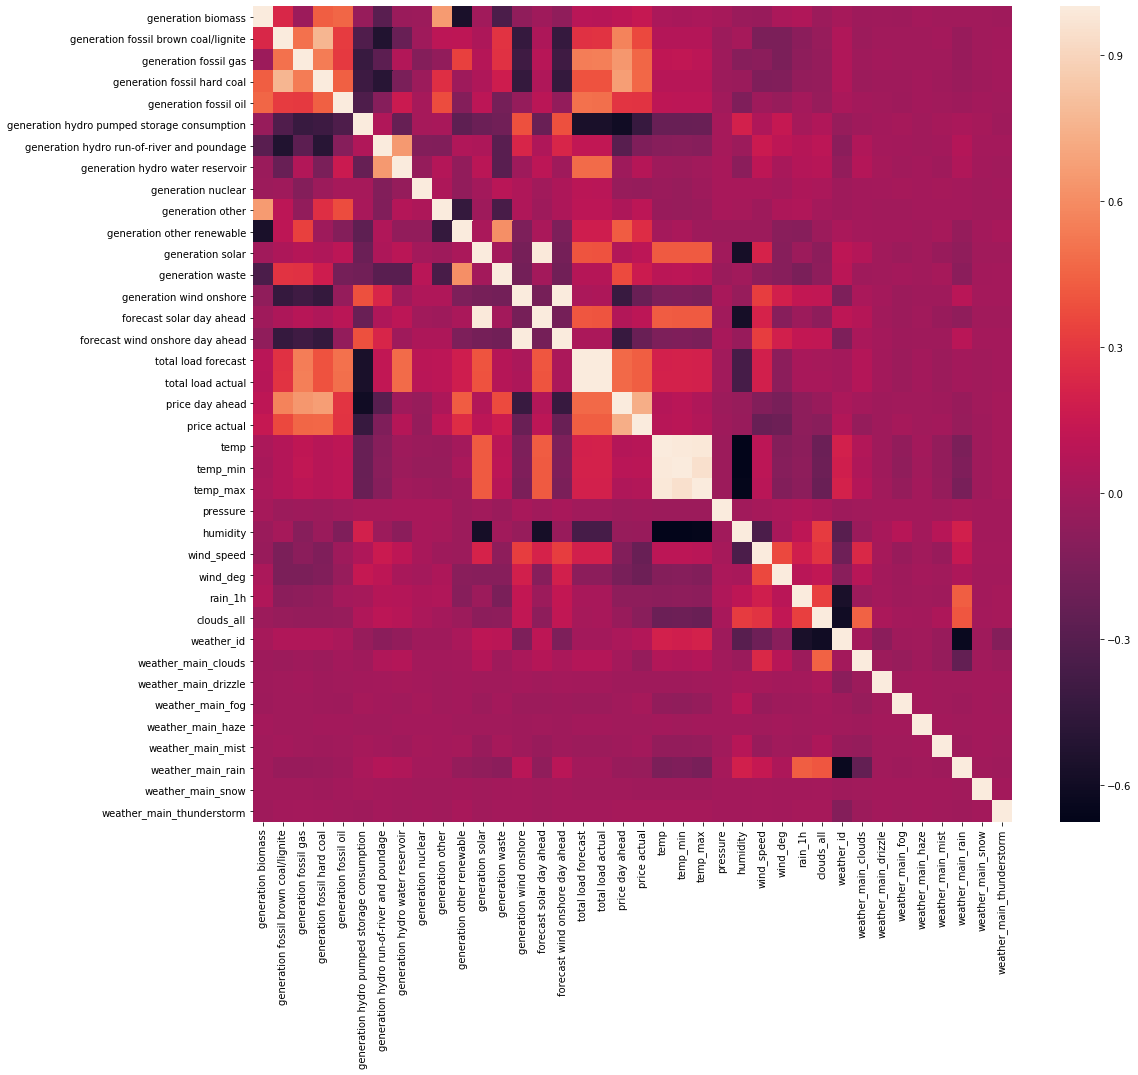

In [15]:
# Check for multicollinearity
corr = dums.corr()
plt.figure(figsize=(17,15))
sns.heatmap(corr)
plt.show()

In [16]:
# Drop collinear variables after interpreting the heatmap
manual_drop_cols = [col for col in dums.columns if 'forecast' in col or 'price' in col or 'total' in col]
manual_drop_cols += ['temp_min', 'temp_max']
manual_drop_cols

['forecast solar day ahead',
 'forecast wind onshore day ahead',
 'total load forecast',
 'total load actual',
 'price day ahead',
 'price actual',
 'temp_min',
 'temp_max']

In [17]:
dums.drop(manual_drop_cols, axis=1, inplace=True)
dums

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,clouds_all,weather_id,weather_main_clouds,weather_main_drizzle,weather_main_fog,weather_main_haze,weather_main_mist,weather_main_rain,weather_main_snow,weather_main_thunderstorm
0,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,...,0.0,800.0,0,0,0,0,0,0,0,0
1,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,...,0.0,800.0,0,0,0,0,0,0,0,0
2,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,...,0.0,800.0,0,0,0,0,0,0,0,0
3,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,...,0.0,800.0,0,0,0,0,0,0,0,0
4,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,...,0.0,800.0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,297.0,0.0,7634.0,2628.0,178.0,1.0,1135.0,4836.0,6073.0,63.0,...,0.0,800.0,0,0,0,0,0,0,0,0
35060,296.0,0.0,7241.0,2566.0,174.0,1.0,1172.0,3931.0,6074.0,62.0,...,0.0,800.0,0,0,0,0,0,0,0,0
35061,292.0,0.0,7025.0,2422.0,168.0,50.0,1148.0,2831.0,6076.0,61.0,...,0.0,800.0,0,0,0,0,0,0,0,0
35062,293.0,0.0,6562.0,2293.0,163.0,108.0,1128.0,2068.0,6075.0,61.0,...,0.0,800.0,0,0,0,0,0,0,0,0


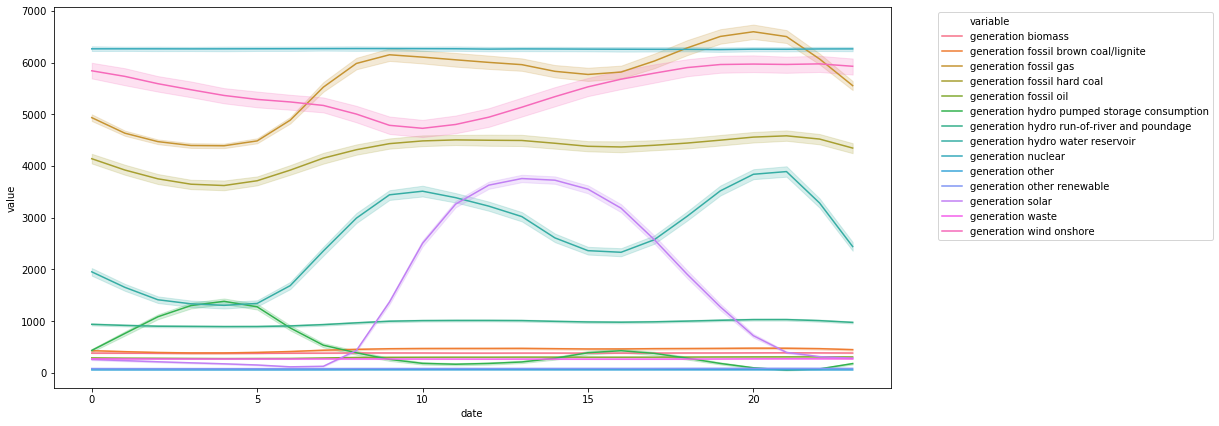

In [18]:
# Explore the behavior of generation columns to help us choose a model
generation_cols = [col for col in dums.columns if 'generation' in col]
plot_df = dums[generation_cols + ['date']]
melted_df = plot_df.melt(id_vars='date')
plt.figure(figsize=(15,7))
sns.lineplot(x=melted_df['date'].dt.hour, y=melted_df['value'], hue=melted_df['variable'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

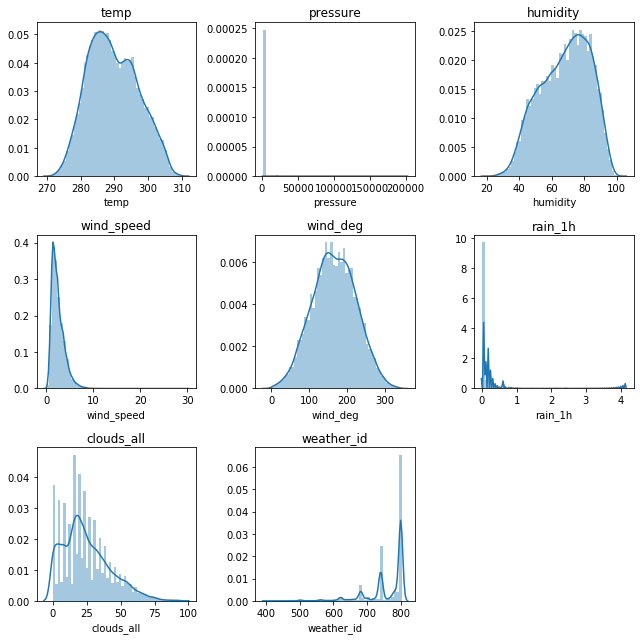

In [19]:
# Explore the distributions of the weather variables
weather_main_cols = [col for col in dums.columns if 'weather_main' in col]
dist_df = dums.drop(generation_cols + weather_main_cols + ['date'], axis=1)

def plot_dist(df, col):
    sns.distplot(dist_df[col])

ds.make_subplots(dist_df, plot_dist)

In [20]:
dums['hour'] = dums['date'].dt.hour
dums['month'] = dums['date'].dt.month
dums['year'] = dums['date'].dt.year

In [21]:
from sklearn.model_selection import train_test_split

# Spleat features and target into train and test splits
X = dums.drop(['generation solar', 'date'], axis = 1)
Y = dums['generation solar']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .1)

In [22]:
from sklearn.ensemble import RandomForestRegressor

# Test the Random Forest Regressor model
rfr = RandomForestRegressor(max_depth=8)
rfr.fit(X_train, Y_train)

print(rfr.score(X_train, Y_train))
print(rfr.score(X_test, Y_test))

0.8357792597598294
0.8113099885458034


In [23]:
from sklearn.ensemble import GradientBoostingRegressor

# Test the Gradient Boosting Regressor model
gbr = GradientBoostingRegressor()
gbr.fit(X_train, Y_train)
print(gbr.score(X_train, Y_train))
print(gbr.score(X_test, Y_test))



0.8485021151414056
0.8376891049229354


In [24]:
pd.Series(gbr.feature_importances_, index=X_train.columns).sort_values(ascending=False)

hour                                           0.711672
humidity                                       0.174057
generation wind onshore                        0.027703
temp                                           0.022068
generation nuclear                             0.021702
month                                          0.008224
generation fossil gas                          0.005884
generation hydro run-of-river and poundage     0.004770
generation fossil hard coal                    0.004598
generation hydro water reservoir               0.004377
generation fossil oil                          0.003571
generation other                               0.002609
generation hydro pumped storage consumption    0.001514
generation biomass                             0.001414
generation waste                               0.001404
generation other renewable                     0.001274
generation fossil brown coal/lignite           0.000759
clouds_all                                     0

In [25]:
from sklearn.linear_model import LinearRegression

# Test a linear regression model
lrm = LinearRegression()
lrm.fit(X_train, Y_train)
print(lrm.score(X_train, Y_train))
print(lrm.score(X_test, Y_test))

0.4187626686051789
0.3933768600549007


In [26]:
from sklearn.model_selection import RandomizedSearchCV

rs = RandomizedSearchCV(
    gbr,
    param_distributions = {'n_estimators': [10, 100, 1000, 5000],
                        'max_features': [2,4,8,16],
                        'learning_rate': [.05,.1,.2,.4,.8,1],
                        'max_depth': [4,8,16]},
    cv=5)

rs.fit(X_train, Y_train)
print(rs.best_params_)
print(rs.best_score_)

{'n_estimators': 5000, 'max_features': 16, 'max_depth': 8, 'learning_rate': 0.05}
0.9631915801283674


In [32]:
from sklearn.ensemble import RandomForestRegressor

# Implement the Random Forest Regressor with optimized hyperparameters
gbr_best = GradientBoostingRegressor(
    max_depth=rs.best_params_['max_depth'],
    n_estimators=rs.best_params_['n_estimators'],
    max_features=rs.best_params_['max_features'],
    learning_rate=rs.best_params_['learning_rate'])
gbr_best.fit(X_train, Y_train)

print(gbr_best.score(X_train, Y_train))
print(gbr_best.score(X_test, Y_test))

0.9999940210770935
0.969659226453999


In [33]:
pd.Series(gbr.feature_importances_, index=X_train.columns).sort_values(ascending=False)

hour                                           0.711672
humidity                                       0.174057
generation wind onshore                        0.027703
temp                                           0.022068
generation nuclear                             0.021702
month                                          0.008224
generation fossil gas                          0.005884
generation hydro run-of-river and poundage     0.004770
generation fossil hard coal                    0.004598
generation hydro water reservoir               0.004377
generation fossil oil                          0.003571
generation other                               0.002609
generation hydro pumped storage consumption    0.001514
generation biomass                             0.001414
generation waste                               0.001404
generation other renewable                     0.001274
generation fossil brown coal/lignite           0.000759
clouds_all                                     0

## Evaluate
### Print metrics for the test

In [34]:
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_absolute_error

preds = gbr_best.predict(X_test)

ds.print_evaluation_metrics(Y_test, preds)

Mean absolute error of the prediction is: 186.4231502051869
Mean squared error of the prediction is: 84078.18536937847
Root mean squared error of the prediction is: 289.9623861285778
Mean absolute percentage error of the prediction is: 86.88281121538891


## 5. Results
While the model could use some improvement, given the time constraint on this project, a score of .81 was a satisfactory enough R^2 to support the idea that yes, you can predict solar generation at an hour given other generations and weather. 

## 6. Discussion and Recommendation
Solar is still a pretty hot topic for homeowners and energy production companies around the globe. While it is important to remember that without seemingly impossible storage systems and planning, it is not a viable baseload solution. Knowing how much production to expect at any time of the day is vital to keeping the energy demand met and preventing transmission overloads.

If I were to take this project further, I would use the time-series attributes of my data to create a forecast model that could predict future generation instead of current generation.